Goal: understand raw `categories` vs `broad_category`, and refine mapping later.

In [1]:
%load_ext autoreload
%autoreload 2

Cell 1 – imports & config

In [2]:
import os
import sys
from pathlib import Path

# Silence TF warnings (if TF is imported indirectly)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Robust project root resolver
def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / 'configs' / 'base.yaml').exists() and (p / 'src').exists():
            return p
    raise FileNotFoundError('Could not locate project root (expected configs/base.yaml and src/)')

PROJECT_ROOT = find_project_root(Path.cwd())

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: /home/spark/NUST/Semester 5/Data Mining/Project


In [3]:
from src.data.load import (
    load_yaml,
    load_all_sources,
    add_broad_category,
    load_category_mapping,
)

CONFIG_PATH = PROJECT_ROOT / 'configs' / 'base.yaml'
print(f'CONFIG_PATH: {CONFIG_PATH}')

CONFIG_PATH: /home/spark/NUST/Semester 5/Data Mining/Project/configs/base.yaml


Cell 2 – load config + data + broad categories

In [4]:
cfg = load_yaml(CONFIG_PATH)
print('Config loaded.')

Config loaded.


In [5]:
df_raw = load_all_sources(cfg, root=PROJECT_ROOT)
print('Data loaded:', df_raw.shape)

INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/s

Data loaded: (40000, 7)


In [6]:
df = add_broad_category(df_raw, cfg, root=PROJECT_ROOT)

df[['source', 'categories', 'broad_category']].head()

,source,categories,broad_category
0,Daily Times,World,World
1,Daily Times,Pakistan,Pakistan
2,Daily Times,Pakistan,Pakistan
3,Daily Times,Pakistan & Top Stories,Pakistan
4,Daily Times,World,World


Cell 3 – top raw categories overall

In [7]:
df['categories'].value_counts().head(50)

categories
Pakistan                                9927
World                                   6265
Business                                5594
National                                3530
Sports                                  3501
Lifestyle                               1211
Sport                                    923
Technology                               581
National & Top Headlines                 529
Comment & Opinion                        485
E-Papers & Pakistan Today                432
Letters & Opinion                        396
Op-Ed                                    376
Pakistan & Top Stories                   363
Punjab                                   333
Sindh                                    308
Reviews                                  292
Cricket                                  272
Editorials & Opinion                     263
Headlines & National                     254
Editorial                                240
Film                                     206

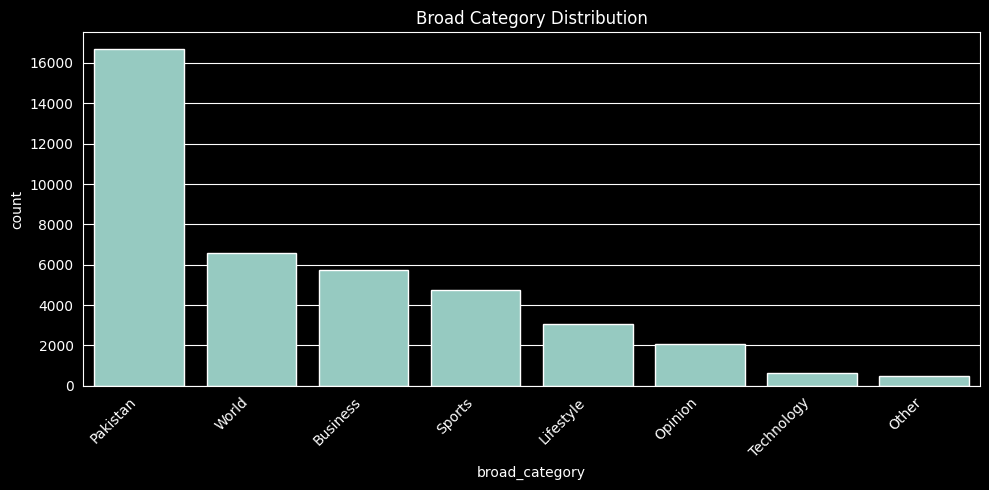

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(
    data=df,
    x="broad_category",
    order=df["broad_category"].value_counts().index,
)
plt.xticks(rotation=45, ha="right")
plt.title("Broad Category Distribution")
plt.tight_layout()
plt.show()


Cell 4 – top raw categories per source

In [9]:
for src in df['source'].unique():
    print(f'=== {src} ===')
    print(df[df['source'] == src]['categories'].value_counts().head(20))

=== Daily Times ===
categories
Pakistan                   2978
Sports                     1367
Lifestyle                  1211
World                      1160
Business                   1015
Op-Ed                       376
Pakistan & Top Stories      363
Reviews                     292
Editorial                   157
Infotainment                123
Arts, Culture & Books       104
Cartoons                     85
Perspectives                 81
Commentary / Insight         64
Uncategorized                63
Top Stories & World          57
Infotainment & Trending      43
Pakistan & World             32
Top Stories                  30
Blogs                        23
Name: count, dtype: int64
=== Dawn ===
categories
Pakistan    5277
World       2429
Business    1361
Sport        923
Prism         10
Name: count, dtype: int64
=== Pakistan Today ===
categories
National                                3530
Business                                2007
World                                    844

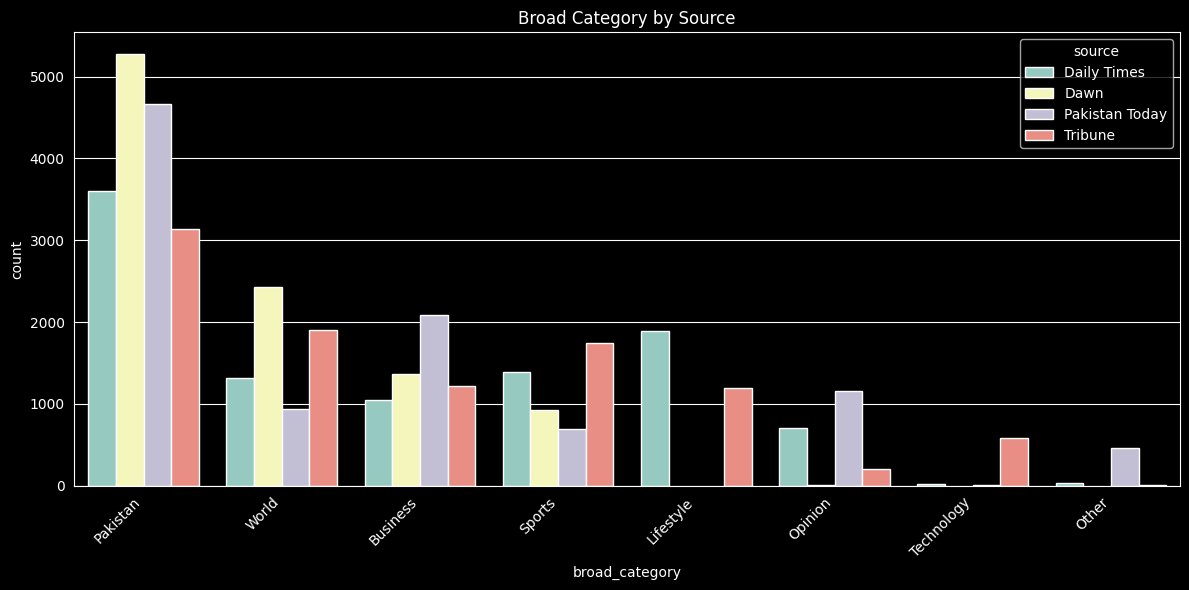

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df,
    x="broad_category",
    hue="source",
    order=df["broad_category"].value_counts().index,
)
plt.xticks(rotation=45, ha="right")
plt.title("Broad Category by Source")
plt.tight_layout()
plt.show()


Cell 5 – confusion between raw and broad (crosstab)

In [11]:
ct = pd.crosstab(df['categories'], df['broad_category'])

# Print number of categories in actual
print(f'Number of unique raw categories: {ct.shape[0]}')
print(f'Number of unique broad categories: {ct.shape[1]}')
ct.head(20)

Number of unique raw categories: 370
Number of unique broad categories: 8


broad_category,Business,Lifestyle,Opinion,Other,Pakistan,Sports,Technology,World
categories,,,,,,,,
Analysis & Headlines,0,0,1,0,0,0,0,0
Analysis & National,0,0,1,0,0,0,0,0
Art & Books,0,20,0,0,0,0,0,0
"Arts, Culture & Books",0,104,0,0,0,0,0,0
"Arts, Culture & Books & Trending",0,1,0,0,0,0,0,0
Azad Jammu & Kashmir,0,0,0,0,3,0,0,0
Balochistan,0,0,0,0,88,0,0,0
Balochistan & Pakistan,0,0,0,0,6,0,0,0
Balochistan & Pakistan & Top Stories,0,0,0,0,1,0,0,0


We can use this to spot:
- Raw categories that are mapping to `Other`
- Raw categories that map to multiple broad categories (maybe noisy)

Cell 6 – focus on `Other` to fix mapping

In [12]:
other_df = df[df['broad_category'] == 'Other']
len(other_df), other_df['categories'].nunique()


(489, 13)

In [13]:
other_df['categories'].value_counts().head(50)


categories
E-Papers & Pakistan Today     432
Headlines                      20
Uncategorized                  10
Trending                        6
Top Stories                     4
Letters                         4
Magazine                        3
Entertainment                   3
E-Papers & Profit Magazine      2
Rawalpindi                      2
Off-Beat                        1
Featured                        1
Health                          1
Name: count, dtype: int64